In [73]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from keras.models import load_model
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm
import keras.backend as K
from glob import glob
from os.path import join
import logging

In [38]:
class MinMaxScaler2D(object):
    """
    Rescale input arrays of shape (examples, y, x, variable) to range from out_min to out_max.

    """
    def __init__(self, out_min=0, out_max=1, scale_values=None):
        self.out_min = out_min
        self.out_max = out_max
        self.out_range = out_max - out_min
        self.scale_values = scale_values

    def fit(self, x, y=None):
        """
        Calculate the values for the min/max transformation.
        """
        vars = np.arange(x.shape[-1])
        self.scale_values = pd.DataFrame(0, index=vars, columns=["min", "max"])
        for v in vars:
            self.scale_values.loc[v, "min"] = x[:, :, :, v].min()
            self.scale_values.loc[v, "max"] = x[:, :, :, v].max()
            self.scale_values.loc[v, "range"] = self.scale_values.loc[v, "max"] - self.scale_values.loc[v, "min"]

    def transform(self, x):
        """
        Apply the min/max scaling transformation.
        """
        if x.shape[-1] != self.scale_values.index.size:
            raise ValueError("Input x does not have the correct number of variables")
        x_new = np.zeros(x.shape, dtype=x.dtype)
        for v in self.scale_values.index:
            x_new[:, :, :, v] = (x[:, :, :, v] - self.scale_values.loc[v, "min"]) \
                / (self.scale_values.loc[v, "range"])
            if self.out_min != 0 or self.out_max != 1:
                x_new[:, :, :, v] = x_new[:, :, :,v] * self.out_range + self.out_min
        return x_new

    def fit_transform(self, x, y=None):
        self.fit(x, y)
        return self.transform(x)
def load_single_data_file(filename, image_variable="abi", count_variable="flash_counts", time_variable="time"):
    ds = xr.open_dataset(filename)
    imagery = ds.variables[image_variable].values
    counts = ds.variables[count_variable].values
    time = ds.variables[time_variable].values
    ds.close()
    return imagery, counts, time


def load_data_serial(data_path, image_variable="abi", count_variable="flash_counts", time_variable="time"):
    data_files = sorted(glob(join(data_path, "*.nc")))
    images_list = []
    counts_list = []
    time_list = []
    for data_file in data_files:
        logging.info(data_file)
        images, counts, time = load_single_data_file(data_file, image_variable=image_variable,
                                                     count_variable=count_variable, time_variable=time_variable)
        images_list.append(images)
        counts_list.append(counts)
        time_list.append(time)
    all_images = np.concatenate(images_list)
    all_counts = np.concatenate(counts_list)
    all_time = pd.DatetimeIndex(np.concatenate(time_list))
    return all_images, all_counts, all_time

In [3]:
all_images, all_counts, all_times = load_data_serial("../data/")

In [43]:
all_images[np.isnan(all_images)] = np.nanmax(all_images)

In [66]:
scaler = MinMaxScaler2D()
scaled_images = 1.0 - scaler.fit_transform(all_images)

In [50]:
scaler.scale_values

,min,max,range
0,0.0000,149.380997,149.380997
1,-0.8236,149.380997,150.204597
2,-0.9561,149.380997,150.337097
3,0.0000,149.380997,149.380997


In [41]:
scaled_images.max()

/glade/work/dgagne/ncar_pylib_dl/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


nan

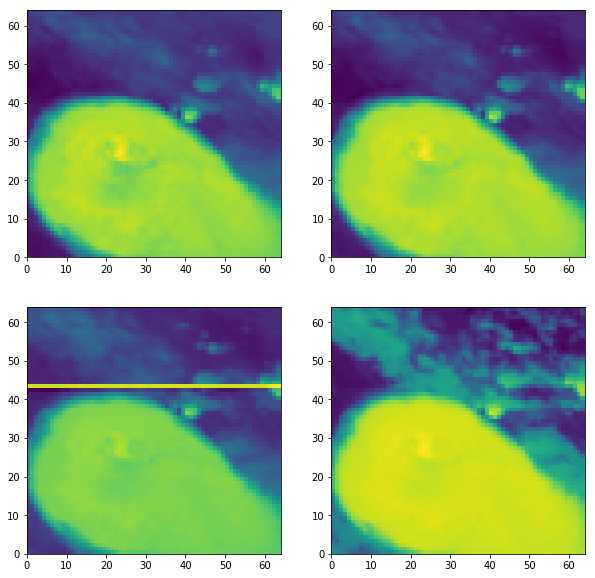

In [122]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for a, ax in enumerate(axes.ravel()):
    ax.pcolormesh(scaled_images[59211, :, :, a], cmap="viridis")

In [14]:
all_images.shape

(84960, 64, 64, 4)

In [4]:
config = K.tf.ConfigProto(allow_soft_placement=False)
config.gpu_options.allow_growth = True
sess = K.tf.Session(config=config)
K.set_session(sess)

In [28]:
res_model = load_model("../goes16_resnet_gpus_01.h5")

In [6]:
res_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
scn_input (InputLayer)          (None, 64, 64, 4)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 64, 64, 32)   3232        scn_input[0][0]                  
__________________________________________________________________________________________________
bn_res_00_a (BatchNormalization (None, 64, 64, 32)   128         conv2d_5[0][0]                   
__________________________________________________________________________________________________
res_activation_00_a (Activation (None, 64, 64, 32)   0           bn_res_00_a[0][0]                
__________________________________________________________________________________________________
res_conv_0

In [29]:
loss = (res_model.output - 1) ** 2
grad = K.gradients(loss, res_model.input)[0]
#grad /= K.maximum(K.std(grad), K.epsilon())
grad_func = K.function([res_model.input, K.learning_phase()], [grad, loss])

In [54]:
#input_field = 0.5 * np.ones((1, 64, 64, 4), dtype=np.float32)
input_field = scaled_images[all_counts.argmax():all_counts.argmax() + 1]
print(input_field.shape)
for i in range(30):
    grad, loss = grad_func([input_field, 0])
    print(loss)
    input_field -= grad

(1, 64, 64, 4)
[[0.988608]]
[[0.98635507]]
[[0.9829839]]
[[0.9773905]]
[[0.967]]
[[0.943354]]
[[0.86732376]]
[[0.43239093]]
[[0.00018227]]
[[0.00017992]]
[[0.00017777]]
[[0.00017577]]
[[0.00017364]]
[[0.00017183]]
[[0.00016988]]
[[0.00016778]]
[[0.00016603]]
[[0.0001642]]
[[0.00016236]]
[[0.00016058]]
[[0.00015896]]
[[0.00015731]]
[[0.00015567]]
[[0.0001541]]
[[0.0001524]]
[[0.00015091]]
[[0.00014927]]
[[0.00014794]]
[[0.00014654]]
[[0.00014492]]


In [114]:
input_field_data = scaled_images[10095:10096]
grad, loss = grad_func([input_field_data, 0])

In [90]:
min_values = scaled_images[:, :, :, 0].min(axis=2).min(axis=1)

In [113]:
min_values.argmin()

10095

In [53]:
scaled_images.argmax()

1196032

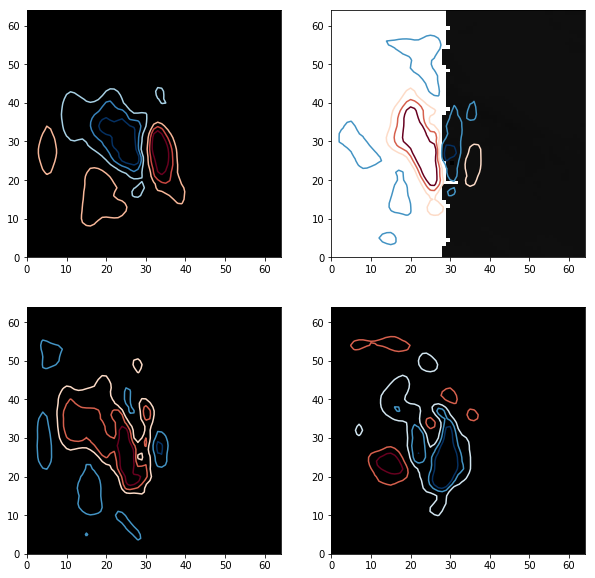

In [118]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for a, ax in enumerate(axes.ravel()):
    ax.pcolormesh(all_images[10095, :,:, a], cmap="Greys_r")
    ax.contour(gaussian_filter(grad[0, :, :, a], 1) / grad[0, :, :, a].std(), [-3, -2, -1, 1, 2, 3], cmap="RdBu_r")

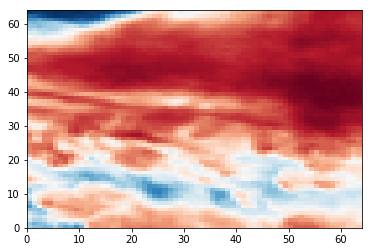

In [112]:
plt.pcolormesh(all_images[2, :, :, 0 ] - all_images[2, :, :, 2], cmap="RdBu_r")

In [106]:
all_counts[8]

1

In [120]:
all_maxes = all_images[:, :, :, 0].max(axis=2).max(axis=1)
all_mins = all_images[:, :, :, 0].min(axis=2).max(axis=1)

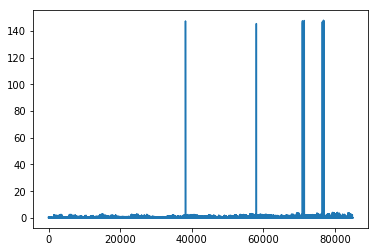

In [121]:
plt.plot(all_maxes - all_mins)